In [ ]:
%reset

In [2]:
import os
import numpy as np
import pandas as pd

os.chdir('/home/vivek/Downloads/kaggle_ndsb2-master/data_segmenter_trainset')
print(os.getcwd())

/home/vivek/Downloads/kaggle_ndsb2-master/data_segmenter_trainset


/home/vivek/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/vivek/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
path = os.listdir()
#gives us the matching annotated images with their masks in a dataframe.  just the strings
pairing_table = pd.read_csv('train1.lst',delimiter='\t',names=['image','mask'])
pairing_table.head()
print(type(pairing_table['image'][0]))

<class 'str'>


In [4]:
pairing_table.shape

(9068, 2)

In [5]:
#visualize the images one by one
from PIL import Image

def viz_help(path):
    img = Image.open(path)
    img.show()
    
def vizs(image_name):
    viz_help('/home/vivek/Downloads/kaggle_ndsb2-master/data_segmenter_trainset/'+image_name)

vizs('0001_00000sax_12_09899_IM-4567-0012.png')


In [6]:
image_table = pairing_table


In [7]:
path = '/home/vivek/Downloads/kaggle_ndsb2-master/data_segmenter_trainset/'


for ii in range(0,2000):
    new_path = os.path.join(path,image_table['image'][ii])
    img = Image.open(new_path)
    img2 = np.array(img.getdata()).reshape(184, 184, -1)
    image_table['image'][ii] = img2
    img.close()
    
    
for ii in range(0,2000):
    new_path = os.path.join(path,image_table['mask'][ii])
    img = Image.open(new_path)
    img2 = np.array(img.getdata()).reshape(184, 184, -1)
    image_table['mask'][ii] = img2
    img.close()
    


print(image_table['image'][0].shape)
print(image_table['image'].shape)
print(image_table['mask'][0].shape)
print(image_table['mask'].shape)

(184, 184, 1)
(9068,)
(184, 184, 1)
(9068,)


In [8]:
#convert our data into the proper format to feed into the neural network

x = np.stack(image_table['image'][:2000].values)
print(type(x),x.shape)

y = np.stack(image_table['mask'][:2000].values)
print(type(y),y.shape)

<class 'numpy.ndarray'> (2000, 184, 184, 1)
<class 'numpy.ndarray'> (2000, 184, 184, 1)


In [9]:
#load in validation table

validate_pairing_table = pd.read_csv('validate1.lst',delimiter='\t',names=['image','mask'])

val_image_table = validate_pairing_table

<class 'str'>


In [10]:
for ii in range(0,100):
    new_path = os.path.join(path,val_image_table['image'][ii])
    img = Image.open(new_path)
    img2 = np.array(img.getdata()).reshape(184, 184, -1)
    val_image_table['image'][ii] = img2
    img.close()
    
    
for ii in range(0,100):
    new_path = os.path.join(path,val_image_table['mask'][ii])
    img = Image.open(new_path)
    img2 = np.array(img.getdata()).reshape(184, 184, -1)
    val_image_table['mask'][ii] = img2
    img.close()
    

In [11]:
from sklearn.model_selection import train_test_split



x_train, x_test, y_train, y_test = train_test_split( x,y, random_state = 2018, test_size = 0.25)
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
print(x_train.shape, x_test.shape)


/home/vivek/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/vivek/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


(1500, 184, 184, 1) (500, 184, 184, 1)


In [16]:
#convert into tensor of proper shape
print(type(image_table['image'])) 

<class 'pandas.core.series.Series'>


In [17]:
#import keras dependencies
import keras
from keras import Sequential,Model
from keras.optimizers import Adam,SGD
from keras.layers import Input, Dense, Concatenate, Dropout
from keras.layers import Conv2D, MaxPool2D, Activation, UpSampling2D,Conv2DTranspose, concatenate
from keras.layers.merge import Concatenate
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import skimage.io as io
import skimage.transform as trans
from keras import backend as K
K.set_image_data_format('channels_last')


inputs = Input(shape = (184,184,1))

#First Block
b1_conv1 = Conv2D(64,(3,3),activation='relu',padding='same',kernel_initializer = 'glorot_normal')(inputs)
b1_conv2 = Conv2D(64,(3,3),activation='relu',padding='same',kernel_initializer = 'glorot_normal')(b1_conv1)
b1_pool = MaxPool2D((2,2))(b1_conv2)  
drop1= Dropout(0.2)(b1_pool)

#Second Block
b2_conv1 = Conv2D(128,(3,3),activation='relu',padding='same',kernel_initializer = 'glorot_normal')(b1_pool)
b2_conv2 = Conv2D(128,(3,3),activation='relu',padding='same')(b2_conv1)
b2_pool = MaxPool2D((2,2))(b2_conv2)
drop2= Dropout(0.2)(b2_pool)

#Third Block
b3_conv1 = Conv2D(256,(3,3),activation='relu',padding='same')(b2_pool)
b3_conv2 = Conv2D(256,(3,3),activation='relu',padding='same')(b3_conv1)
b3_pool = MaxPool2D((2,2))(b3_conv2)
drop3= Dropout(0.2)(b3_pool)

#Fourth Block
b4_conv1 = Conv2D(512,(3,3),activation='relu',padding='same')(b3_pool)
b4_conv2 = Conv2D(512,(3,3),activation='relu',padding='same')(b4_conv1)
b4_up = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(b4_conv2)
drop4= Dropout(0.2)(b4_up)


#Fifth Block
b5_concat = concatenate([drop4, b3_conv2], axis=3)
b5_conv1 = Conv2D(256,(3,3),activation='relu',padding='same')(b5_concat)
b5_conv2 = Conv2D(256,(3,3),activation='relu',padding='same')(b5_conv1)
b5_up = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b5_conv2)
drop5= Dropout(0.2)(b5_up)

#Sixth Block
b6_concat = concatenate([drop5, b2_conv2], axis=3)
b6_conv1 = Conv2D(128,(3,3),activation='relu',padding='same')(b6_concat)
b6_conv2 = Conv2D(128,(3,3),activation='relu',padding='same')(b6_conv1)
b6_up = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(b6_conv2)
drop6= Dropout(0.2)(b6_up)


#Output
output_layer1 = Conv2D(2,(3,3),activation='relu',padding='same')(drop6)
output_layer = Conv2D(1,(1,1),activation='sigmoid',padding='same')(output_layer1)


 


model = Model(inputs =inputs,outputs=output_layer)
model.summary()

 


Using TensorFlow backend.
/home/vivek/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/vivek/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  return f(*args, **kwds)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 184, 184, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 184, 184, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 184, 184, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 92, 92, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [18]:

from keras import optimizers




smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

adam = optimizers.Adam(lr=0.01)

model.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef], loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None)



In [19]:
print(x.shape,y.shape)

(2000, 184, 184, 1) (2000, 184, 184, 1)


In [20]:
import matplotlib.pyplot as plt

def plot(history, save_path = None, dpi=600):
    plt.figure()
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('dice')

In [21]:
history = model.fit(x_train, y_train, epochs=20, batch_size=1, validation_split=0.2, verbose=1)

Train on 1200 samples, validate on 300 samples
Epoch 1/20
1200/1200 [==============================] - 29s 24ms/step - loss: -1.4595 - dice_coef: 1.4595 - val_loss: -1.4376 - val_dice_coef: 1.4376
Epoch 2/20
1200/1200 [==============================] - 26s 21ms/step - loss: -1.4599 - dice_coef: 1.4599 - val_loss: -1.4376 - val_dice_coef: 1.4376
Epoch 3/20
1200/1200 [==============================] - 25s 21ms/step - loss: -1.4599 - dice_coef: 1.4599 - val_loss: -1.4376 - val_dice_coef: 1.4376
Epoch 4/20
1200/1200 [==============================] - 25s 21ms/step - loss: -1.4599 - dice_coef: 1.4599 - val_loss: -1.4376 - val_dice_coef: 1.4376
Epoch 5/20
1200/1200 [==============================] - 25s 21ms/step - loss: -1.4599 - dice_coef: 1.4599 - val_loss: -1.4376 - val_dice_coef: 1.4376
Epoch 6/20
1200/1200 [==============================] - 26s 21ms/step - loss: -1.4599 - dice_coef: 1.4599 - val_loss: -1.4376 - val_dice_coef: 1.4376
Epoch 7/20
1200/1200 [==============================]

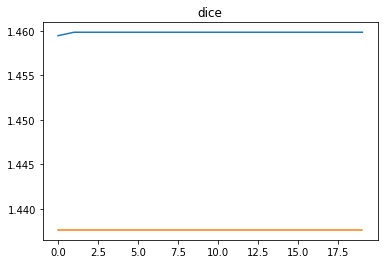

In [22]:
plot(history)